# ОКПД 2 (по новостям и чисто по названиям)

In [ ]:
%%capture
!pip install iterative-stratification
!pip install scikit-multilearn
!pip install transformers
!pip install -U imbalanced-learn

In [ ]:
%cp /content/drive/MyDrive/OKPD2/okpds_unique.tar.gz .
!tar -xzf okpds_unique.tar.gz

датасет окпд2 из новостей

In [ ]:
import pandas as pd
df = pd.read_csv(r'/content/mnt/appdata/nlp/okpd/okpds4_unique',sep='\t',header=None)

df.columns = ['text','okpd']
df['l1'] = df.okpd.apply(lambda a: a.split('.')[0])
df['l2'] = df.okpd.apply(lambda a: '.'.join(a.split('.')[0:2]))

to_drop = ['E', 'J', 'ё', 'S', 'P', 'D', 'T', 'G', 'A', 'F', 'Q', 'C', 'I','M', 'N', 'H', 'O', 'j','46']
df = df[~df.l1.isin(to_drop)].copy()

датасет окпд2 из чистых названий

In [ ]:
df_2 = pd.read_excel(r'/content/drive/MyDrive/OKPD2/okpd2_only.xlsx', index_col=None, header=None)[1:]
df_2.columns = ['okpd','text']

df_2['l1'] = df_2.okpd.apply(lambda a: str(a).split('.')[0])
df_2['l2'] = df_2.okpd.apply(lambda a: '.'.join(a.split('.')[0:2]))
df_2.head()

,okpd,text,l1,l2
1,01,Продукция и услуги сельского хозяйства и охоты,01,01
2,01.1,Культуры однолетние,01,01.1
3,01.11,"Культуры зерновые (кроме риса), зернобобовые, ...",01,01.11
4,01.11.1,Пшеница,01,01.11
5,01.11.11,Пшеница твердая,01,01.11


In [ ]:
df.head(3)

,text,okpd,l1,l2
0,услуги по передаче электроэнергии,35.12.10.110,35,35.12
1,оказание услуг по вывозу и размещению твердых ...,38.11.11.000,38,38.11
2,"салфетки (повязки), расфасованные в формы или ...",21.20.24.160,21,21.20


In [ ]:
df_2.head(3)

,okpd,text,l1,l2
1,01,Продукция и услуги сельского хозяйства и охоты,01,01
2,01.1,Культуры однолетние,01,01.1
3,01.11,"Культуры зерновые (кроме риса), зернобобовые, ...",01,01.11


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from transformers import BertTokenizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from skmultilearn.model_selection import IterativeStratification
from skmultilearn.model_selection import iterative_stratification

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import balanced_accuracy_score

## ОКПД из новостей

Первый уровень

In [ ]:
newone = pd.concat([df[df.l1 == i].head(3000) for i in df.l1.unique()])
newone.l1.value_counts()
df = newone.copy()

или второй

In [ ]:
newone = pd.concat([df[df.l2 == i].head(100) for i in df.l2.unique()])
newone.l2.value_counts()
df = newone.copy()

чистим

In [ ]:
df.text = df.text.apply(lambda a: a[:150])
df.text.str.len().max()

150

In [ ]:
df = df[df.l2.isin(df.l2.value_counts()[df.l2.value_counts() > 9].index.tolist())]
df.l2.value_counts()

36.00    2997
19.20    2992
37.00    2986
41.20    2941
65.12    2935
         ... 
01.29      10
55.30      10
47.75      10
25.62      10
33.16      10
Name: l2, Length: 501, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import AllKNN 
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

#model = make_pipeline_imb(TfidfVectorizer(), AllKNN(), MultinomialNB())
corpus = df['text'].values
tokenizer = BertTokenizer.from_pretrained("cointegrated/rubert-tiny", lower_case=False)

X = df['text'].values
y = df['l1'].to_numpy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,
                               random_state=1337, stratify=y)



tfidf_ = TfidfVectorizer(
                            tokenizer=tokenizer.tokenize, 
                            ngram_range=(1,6), 
                            lowercase=True,
                            #stop_words=stopwords,
                            max_features = None,
                            analyzer='word',
                            max_df=0.95,
                            min_df=0.001
                            )
clf_ = LinearSVC(C=1, 
                     class_weight='balanced',                             
                     random_state=1337,
                     max_iter=5000)

#clf_ = KNeighborsClassifier()

model = make_pipeline_imb(tfidf_, 
                          RandomUnderSampler(random_state=12),
                          clf_)
model = Pipeline([('tfidf',tfidf_), 
                  ('clf', clf_)
                  ])

model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

In [ ]:
from sklearn.metrics import balanced_accuracy_score

print('weighted f1: ',f1_score(y_valid, y_pred, average='weighted'))
print('micro f1: ',f1_score(y_valid, y_pred, average='micro'))
print('macro f1: ',f1_score(y_valid, y_pred, average='macro'))
print('balanced accuracy score: ',balanced_accuracy_score(y_valid, y_pred))

weighted f1:  0.7125857642501718
micro f1:  0.7167132216014898
macro f1:  0.6747959053521837
balanced accuracy score:  0.696868763188859


## ОКПД из ЧИСТОГО

In [ ]:
from typing import Callable, List, Optional, Tuple

import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
import torch

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(
            self,
            bert_tokenizer,
            bert_model,
            max_length: int = 60,
            embedding_func: Optional[Callable[[torch.tensor], torch.tensor]] = mean_pooling,
    ):
        self.tokenizer = bert_tokenizer
        self.model = bert_model
        self.model.eval()
        self.max_length = max_length
        self.embedding_func = embedding_func

        if self.embedding_func is None:
            self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        # Tokenize the text with the provided tokenizer
        #print('text:',text)
        tokenized_text = self.tokenizer.encode_plus(text,
                                                    add_special_tokens=True,
                                                    max_length=self.max_length
                                                    )["input_ids"]
        #print('tokenized_text:',tokenized_text)
        # Create an attention mask telling BERT to use all words
        attention_mask = [1] * len(tokenized_text)

        # bert takes in a batch so we need to unsqueeze the rows
        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str) -> torch.tensor:
        tokenized, attention_mask = self._tokenize(text)
        embeddings = self.model(tokenized, attention_mask)

        return self.embedding_func(embeddings, attention_mask)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string).squeeze(0) for string in text])

    def fit(self, X, y=None):
        """No fitting necessary so we just return ourselves"""
        return self

In [ ]:
corpus = df_2['text'].values
tokenizer = BertTokenizer.from_pretrained("cointegrated/rubert-tiny", lower_case=False)

X = df_2['text'].values
y = df_2['l1'].to_numpy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,
                               random_state=1337, stratify=y)

In [ ]:
from transformers import AutoTokenizer, AutoModel
from sklearn.pipeline import FeatureUnion
import torch
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import (
   CountVectorizer, TfidfTransformer
)

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny", lower_case=True)#.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

bert_transformer = BertTransformer(tokenizer, model)
classifier = LinearSVC(C=1.0, 
                     class_weight='balanced',                             
                     random_state=1337,
                     max_iter=1000
                     )

#classifier = LogisticRegression()
#classifier = KNeighborsClassifier()

tfidf_ = TfidfVectorizer(
                            tokenizer=tokenizer.tokenize, 
                            ngram_range=(1,6), 
                            lowercase=True,
                            #stop_words=stopwords,
                            max_features = None,
                            analyzer='word',
                            max_df=0.95,
                            min_df=0.001
                            )

tf_idf = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer())
    ])

model = Pipeline([
    ("union", FeatureUnion(transformer_list=[
#        ("bert", bert_transformer),
        ("tf_idf", tf_idf)
        ])),
        ("classifier", classifier),
    ])

model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.predict(['Черные металлы'])

array(['24'], dtype=object)

In [ ]:
from sklearn.metrics import balanced_accuracy_score

print(f1_score(y_valid, y_pred, average='weighted'))
print(f1_score(y_valid, y_pred, average='micro'))
print(f1_score(y_valid, y_pred, average='macro'))
balanced_accuracy_score(y_valid, y_pred)

0.9185496411605141
0.9181739879414298
0.914744871341502


0.91904188069441

In [ ]:
assert model.predict(['мясные консервы']) == '10'
assert model.predict(['пиво']) == '11'
assert model.predict(['нефть']) == '06'
#model.predict(['Черные металлы'])
#assert model.predict(['газ']) == '06'
#assert model.predict(['скоростной поезд']) =='30'

In [ ]:
import pickle

filename = '/content/drive/MyDrive/OKPD2/okpd2_sklearn_wo_bert_l1.pkl'
pickle.dump(model, open(filename, 'wb'))

#loaded_model = pickle.load(open(filename, 'rb'))

## Классы ТН ВЭД ЕАЭС (не сходится)

In [ ]:
new_class = {
    'Черные металлы':'24.1',
    'Цветные металлы':'24.4',
#    'Драгоценные металлы': '24.41',
    'Пшеница': '1.11',
    'Машины и оборудование, электроэнергия':'27',
    'Удобрения': '20.1',
    'Рыба и морепродукты': '10.2',
    'Целлюлоза и бумажные изделия': '17.1',
    'Растительные масла и жиры': '10.4',
    'Автомобили и их части': '29.1',
    'Прочие продукты питания': '10.8',
    'Самолеты и их части': '30.3',
    'Прочие зерновые': '01.11.49',
    'Масличные семена': '01.11.9',
     'Изделия из металлов': '25',
     'Химические продукты':'20',
    'Пластмассы и резина': '22',
     'Электронное оборудование': '26',
      'Инструменты и аппараты оптические, часы и медицинские инструменты': '20.1',
      'Инструменты и аппараты оптические, часы и медицинские инструменты': '20.1',
      'Инструменты и аппараты оптические, часы и медицинские инструменты': '20.1',
 
#    'Инструменты и аппараты оптические, часы и медицинские инструменты': '20.1',
#    'Растительные остатки и корм для животных': '20.1',
#    'Фармацевтическая продукция': '20.1',
#    'Косметика и парфюмерия': '20.1',
#    'Разные промышленные товары': '20.1',
 
#    'Удобрения': '20.1',
}

In [ ]:
aa = set(['30.11.21', '30.11.21', '30.11.22', '30.11.22', '30.11.23', '30.11.23', '30.11.24', '30.11.24', '30.11.31', '30.11.31', '30.12.12', '30.12.12', '30.12.11', '30.12.11', '30.12.19', '30.12.19', '30.12.19', '30.12.19', '30.12.19', '30.12.19', '30.11.32', '30.11.32', '30.11.32', '30.11.33', '30.11.33', '30.11.40', '30.11.33', '30.11.33', '30.11.10', '30.11.33', '30.11.33', '30.11.33', '30.11.50', '30.11.50', '38.11.41'])

In [ ]:
print(set(['.'.join(a.split('.')[0:2]) for a in aa]))

{'30.12', '30.11', '38.11'}


In [ ]:
new_class = {
    'Черные металлы':['07.1', '08', '09', '24.1', '38.1', '24.3'],
    #'Черные металлы':['07.1', '24.10',
    #                  '38.11','24.32','24.31',
    #                  '24.34','24.33'],
    'Цветные металлы':['07.2','24.4'],
#    'Драгоценные металлы': '24.41',
    'Пшеница': ['01.11.1'],
    'Машины и оборудование, электроэнергия':['27.32', '30.30', '28.14', '28.21', '28.41', '28.93', '28.30', '27.12', '28.11', '26.12', '27.90', '23.43', '27.31', '28.94', '25.73', '38.12', '27.11', '28.13', '25.21', '26.20', '27.40', '28.22', '27.52', '27.20', '59.11', '29.10', '28.92', '26.40', '28.95', '59.20', '28.24', '58.29', '28.96', '26.80', '28.23', '29.31', '27.51', '28.99', '20.13', '26.11', '28.25', '26.51', '27.33', '28.49', '23.44', '25.30', '25.99', '26.70', '28.91', '32.50', '25.11', '18.13', '23.19', '28.15', '28.29', '28.12', '26.30'],
    'Удобрения': ['20.15'],
    'Рыба и морепродукты': ['10.20', '03.22', '01.49', '03.12', '03.11'],
    'Целлюлоза и бумажные изделия': ['71.11', '58.13', '17.21', '32.99', '17.22', '17.23', '59.20', '17.24', '58.14', '17.11', '58.19', '38.11', '17.29', '58.11', '17.12'],
    'Растительные масла и жиры': ['10.41', '10.12', '20.41', '01.49', '13.10', '20.59', '10.62', '01.11', '10.42'],
    'Автомобили и их части': ['28.92', '29.20', '29.10', '29.32'],
    'Прочие продукты питания': ['10.8'],
    'Самолеты и их части': ['28.99', '13.92', '30.30'],
    'Прочие зерновые': ['01.11.49','10.61'],
    'Масличные семена': ['01.11','01.16'],
     'Изделия из металлов': ['25'],
     'Химические продукты':['74.20', '20.20', '23.64', '59.11', '23.63', '20.16', '38.21', '23.20', '20.30', '21.20', '38.11', '37.00', '38.12', '23.99', '20.59', '20.14'],
    'Пластмассы и резина': ['01.29', '22.19', '20.16', '02.30', '20.17', '22.21', '22.23', '22.29', '38.11', '22.11', '22.22', '27.33'],
     'Электронное оборудование': {'28.49', '28.94', '28.92', '28.95', '28.24', '26.20', '28.91', '28.41', '18.13', '28.30', '28.93', '28.96', '28.23', '28.99', '28.29', '27.51', '26'},
      'Инструменты и аппараты оптические, часы и медицинские инструменты': ['15.12', '32.20', '32.99', '26.70', '32.13', '27.31', '26.60', '32.50', '32.12', '28.99', '28.29', '26.51', '26.52'],
      'Фармацевтическая продукция': ['21.10', '21.20', '32.50', '22.29', '38.12', '20.14'],
      'Косметика и парфюмерия': ['20.53', '20.42', '20.41'],
     'Растительные остатки и корм для животных': ['10.91', '10.92', '10.39'],
     'Разные промышленные товары': ['31.03', '15.12', '30.30', '32.99', '31.02', '32.30', '29.32', '31.01', '17.22', '16.29', '31.09', '27.40', '16.23', '13.99', '26.40', '23.61', '28.99', '13.92', '25.99', '32.50', '25.11', '32.40', '22.29', '23.19', '32.91'],
    'Железнодорожная техника и ее части':['29.20', '30.20'],
    'Какао-бобы и продукты из них':['10.82', '01.27'],
    'Изделия из стекла':['13.20', '23.14', '38.11', '23.19', '23.11', '23.12', '23.13'],
    'Минеральные продукты':['35.21', '05.10', '07.29', '08.11', '08.91', '07.10', '08.99', '08.12', '23.52', '19.30', '19.20', '19.10', '06.20', '38.11', '20.13', '23.99', '38.12', '08.93', '20.14', '08.92', '05.20', '10.84', '38.21', '06.10', '23.51', '07.21'],
    'Изделия из дерева': ['32.99', '02.30', '16.24', '16.10', '16.29', '16.22', '16.21', '38.11', '02.20', '16.23', '20.14'],
    'Ювелирные изделия и изделия из драгоценных металлов': ['32.12', '32.11', '32.13', '24.41'],
    'Сахар' : ['10.51', '10.82', '10.89', '10.62', '10.81'],
 #   'Табак и изделия из него'
    'Одежда': ['22.19', '14.12', '32.99', '14.39', '14.14', '14.31', '13.94', '22.29', '32.30', '15.20', '14.19', '27.51', '14.13', '13.92'],
    'Мясо (кроме мяса домашней птицы)': ['10.13', '10.11'],
    'Мясо домашней птицы': ['10.12'],
    'Алкогольные напитки': ['11.04', '11.02', '11.03', '11.01', '11.05', '20.14'],
    'Суда, плавучие конструкции и их части': ['30.12', '30.11', '38.11'],
#    'Бобовые': []
#    'Продукция мукомольно-крупяной промышленности'
#    'Синтетические волокна и ткани'
#    'Керамические изделия'
    'Безалкогольные напитки': ['11.07'],
#    'Молочные продукты'
 #   'Обувь'
 #   'Обработанное мясо'
 #   'Овощи'
 #   'Прочие текстильные изделия'
 #   'Кожа и изделия из нее'
 #   'Чай'
 #   'Прочие продукты животного происхождения (съедобные)'
 #   'Продукты из рыбы'
 #   'Хлопок, хлопчатобумажная пряжа, ткани, трикотажные полотна'
 #   'Фрукты'
 #   'Рис'
 #   'Продукты животного происхождения (несъедобные)'
 #   'Кофе'
#    'Инструменты и аппараты оптические, часы и медицинские инструменты': '20.1',
#    'Фармацевтическая продукция': '20.1',
#    'Косметика и парфюмерия': '20.1',
#    'Разные промышленные товары': '20.1',
 
#    'Удобрения': '20.1',
}

In [ ]:
new_class.values()

dict_values([['07.1', '08', '09', '24.1', '38.1', '24.3'], ['07.2', '24.4'], ['01.11.1'], ['27.32', '30.30', '28.14', '28.21', '28.41', '28.93', '28.30', '27.12', '28.11', '26.12', '27.90', '23.43', '27.31', '28.94', '25.73', '38.12', '27.11', '28.13', '25.21', '26.20', '27.40', '28.22', '27.52', '27.20', '59.11', '29.10', '28.92', '26.40', '28.95', '59.20', '28.24', '58.29', '28.96', '26.80', '28.23', '29.31', '27.51', '28.99', '20.13', '26.11', '28.25', '26.51', '27.33', '28.49', '23.44', '25.30', '25.99', '26.70', '28.91', '32.50', '25.11', '18.13', '23.19', '28.15', '28.29', '28.12', '26.30'], ['20.15'], ['10.20', '03.22', '01.49', '03.12', '03.11'], ['71.11', '58.13', '17.21', '32.99', '17.22', '17.23', '59.20', '17.24', '58.14', '17.11', '58.19', '38.11', '17.29', '58.11', '17.12'], ['10.41', '10.12', '20.41', '01.49', '13.10', '20.59', '10.62', '01.11', '10.42'], ['28.92', '29.20', '29.10', '29.32'], ['10.8'], ['28.99', '13.92', '30.30'], ['01.11.49', '10.61'], ['01.11', '01.16'

In [ ]:
#t = [[0,1],[2,3]]
#[df_2[df_2.okpd.str.startswith(item)] for sublist, j in new_class.items() for item in sublist]
pd.concat( [df_2[df_2.okpd.str.startswith(item)].apply(lambda a: foo(a,j), axis=1) for j,sublist in new_class.items() for item in sublist])

,okpd,text,l1,l2
1809,Черные металлы,Руды железные,07,07.1
1810,Черные металлы,Руды железные,07,07.10
1811,Черные металлы,Руды железные,07,07.10
1812,Черные металлы,Руды железные,07,07.10
1813,Черные металлы,Руда железная сырая,07,07.10
...,...,...,...,...
3789,Безалкогольные напитки,Концентраты напитков,11,11.07
3790,Безалкогольные напитки,"Напитки безалкогольные прочие, не включенные в...",11,11.07
3791,Безалкогольные напитки,Услуги по производству минеральных вод и безал...,11,11.07
3792,Безалкогольные напитки,Услуги по производству минеральных вод и безал...,11,11.07


In [ ]:
pd.concat([df_2[df_2.okpd.str.startswith(i)] for i in new_class.values()])

,okpd,text,l1,l2
8202,24.1,"Железо, чугун, сталь и ферросплавы",24,24.1
8203,24.10,"Железо, чугун, сталь и ферросплавы",24,24.10
8204,24.10.1,Продукты из железа и стали основные,24,24.10
8205,24.10.11,"Чугун зеркальный и передельный в чушках, болва...",24,24.10
8206,24.10.11.110,"Чугун зеркальный в чушках, болванках или в про...",24,24.10
...,...,...,...,...
11940,29.32.91.000,Услуги по сборке полных комплектов для автотра...,29,29.32
11941,29.32.92,Услуги по сборке частей и принадлежностей для ...,29,29.32
11942,29.32.92.000,Услуги по сборке частей и принадлежностей для ...,29,29.32
11943,29.32.99,Операции процесса производства прочих частей и...,29,29.32


In [ ]:
def foo(tt,bb):
    tt.okpd = bb
    return tt

#df_3 = pd.concat([df_2[df_2.okpd.str.startswith(i)].apply(lambda a: foo(a,j), axis=1) for j,i in new_class.items()])
df_3 = pd.concat( [df_2[df_2.okpd.str.startswith(item)].apply(lambda a: foo(a,j), axis=1) for j,sublist in new_class.items() for item in sublist])
#df_3.head()
#оставим только по 500
df_3 = pd.concat([df_3[df_3.okpd.str.startswith(i)].head(1000) for i in df_3.okpd.unique()])
df_3.okpd.value_counts()

Разные промышленные товары                                           1000
Одежда                                                               1000
Электронное оборудование                                             1000
Машины и оборудование, электроэнергия                                1000
Минеральные продукты                                                 1000
Химические продукты                                                  1000
Растительные масла и жиры                                             928
Изделия из дерева                                                     921
Инструменты и аппараты оптические, часы и медицинские инструменты     900
Фармацевтическая продукция                                            716
Рыба и морепродукты                                                   636
Черные металлы                                                        630
Изделия из металлов                                                   601
Целлюлоза и бумажные изделия          

In [ ]:
def foo(a,b):
    a.okpd = b
    return a

df_2[df_2.okpd.str.startswith('24.1')].apply(lambda a: foo(a,'ABC'), axis=1)

,okpd,text,l1,l2
8202,ABC,"Железо, чугун, сталь и ферросплавы",24,24.1
8203,ABC,"Железо, чугун, сталь и ферросплавы",24,24.10
8204,ABC,Продукты из железа и стали основные,24,24.10
8205,ABC,"Чугун зеркальный и передельный в чушках, болва...",24,24.10
8206,ABC,"Чугун зеркальный в чушках, болванках или в про...",24,24.10
...,...,...,...,...
8422,ABC,Колеса цельнокатаные,24,24.10
8423,ABC,"Прокат черных металлов прочий, не включенный в...",24,24.10
8424,ABC,"Услуги по производству железа, чугуна, стали и...",24,24.10
8425,ABC,"Услуги по производству железа, чугуна, стали и...",24,24.10


In [ ]:
corpus = df_3['text'].values
tokenizer = BertTokenizer.from_pretrained("cointegrated/rubert-tiny", lower_case=False)

X = df_3['text'].values
y = df_3['okpd'].to_numpy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,
                               random_state=1337, stratify=y)

In [ ]:
from transformers import AutoTokenizer, AutoModel
from sklearn.pipeline import FeatureUnion
import torch
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import (
   CountVectorizer, TfidfTransformer
)

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny", lower_case=False)#.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

bert_transformer = BertTransformer(tokenizer, model)
classifier = LinearSVC(C=1.0, 
                     class_weight='balanced',                             
                     random_state=1337,
                     max_iter=5000
                     )

tfidf_ = TfidfVectorizer(
                            tokenizer=tokenizer.tokenize, 
                            ngram_range=(1,6), 
                            lowercase=True,
                            #stop_words=stopwords,
                            max_features = None,
                            analyzer='word',
                            max_df=0.95,
                            min_df=0.001
                            )

tf_idf = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer())
    ])

model = Pipeline([
    ("union", FeatureUnion(transformer_list=[
 #       ("bert", bert_transformer),
        ("tf_idf", tf_idf),
#        ("tf_idf", tfidf_)
        ])),
        ("classifier", classifier),
    ])

model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(f1_score(y_valid, y_pred, average='weighted'))
print(f1_score(y_valid, y_pred, average='micro'))
print(f1_score(y_valid, y_pred, average='macro'))
balanced_accuracy_score(y_valid, y_pred)
#0.7796329531844257

0.5790699164722406
0.5761676123963335
0.6134016656249512


0.637830783499449

In [ ]:
print(f1_score(y_valid, y_pred, average='weighted'))
print(f1_score(y_valid, y_pred, average='micro'))
print(f1_score(y_valid, y_pred, average='macro'))
balanced_accuracy_score(y_valid, y_pred)

0.47267045268891483
0.4607538802660754
0.6199939459525671


0.701562245735539

In [ ]:
print(f1_score(y_valid, y_pred, average='weighted'))
print(f1_score(y_valid, y_pred, average='micro'))
print(f1_score(y_valid, y_pred, average='macro'))
balanced_accuracy_score(y_valid, y_pred)

0.4880775827758951
0.4802660753880266
0.6191108488030547


0.7453377701341317

In [ ]:
print(f1_score(y_valid, y_pred, average='weighted'))
print(f1_score(y_valid, y_pred, average='micro'))
print(f1_score(y_valid, y_pred, average='macro'))
balanced_accuracy_score(y_valid, y_pred)

0.46760697942233215
0.45498891352549886
0.6112411627380882


0.689807862133358

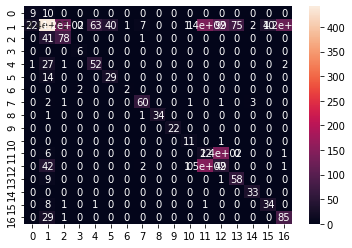

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

sn.heatmap(confusion_matrix(y_valid, y_pred), annot=True)

# TACRED

## ER

In [ ]:
!git clone https://github.com/wzhouad/RE_improved_baseline.git

Cloning into 'RE_improved_baseline'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 32 (delta 12), reused 17 (delta 6), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [ ]:
%cp -r /content/drive/MyDrive/OKPD2/RE_improved_baseline .

In [ ]:
%cd RE_improved_baseline/

!mkdir data
!mkdir ./data/tacred
!cp -r /content/drive/MyDrive/ранхигс/RuRED ./data/tacred

/content/RE_improved_baseline


In [ ]:
%%capture
!pip install transformers ujson wandb

In [ ]:
import wandb
wandb.login()

%env WANDB_WATCH=all
%env WANDB_PROJECT=tacred_ru_2
%env TASK_NAME=tacred_ru_2

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


KeyboardInterrupt: ignored

In [ ]:
%cd /content/RE_improved_baseline

In [ ]:
import json
import pandas as pd

with open(r'/content/RE_improved_baseline/data/tacred/RuRED/train.json','r') as fp:
    train_json = json.load(fp, encoding='utf8')

with open(r'/content/RE_improved_baseline/data/tacred/RuRED/test.json','r') as fp:
    test_json = json.load(fp, encoding='utf8')

with open(r'/content/RE_improved_baseline/data/tacred/RuRED/dev.json','r') as fp:
    dev_json = json.load(fp, encoding='utf8')

In [ ]:
from transformers import AutoTokenizer
model_checkpoint = "cointegrated/rubert-tiny"
#model_checkpoint = r'sberbank-ai/ruRoberta-large'
tokeniser_  = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
tokeniser_(train_json[11]['token'], is_split_into_words=True,)['input_ids'].__len__()

519

In [ ]:
train_new = [i for i in train_json+dev_json if tokeniser_(i['token'], is_split_into_words=True,)['input_ids'].__len__() < 100]
test_new = [i for i in test_json if tokeniser_(i['token'], is_split_into_words=True,)['input_ids'].__len__() < 100]

In [ ]:
%mkdir /content/rured_new

with open(r'/content/rured_new/train.json','w') as fp:
    json.dump(train_new, fp, ensure_ascii=False, indent=4)

with open(r'/content/rured_new/test.json','w') as fp:
    json.dump(test_new, fp, ensure_ascii=False, indent=4)

mkdir: cannot create directory ‘/content/rured_new’: File exists


In [ ]:
set(new_set) - set_of

{'B-LANGUAGE',
 'B-MISC',
 'B-STATE_OR_PROVINCE',
 'B-TOWN_OR_VILLAGE',
 'I-BOROUGH',
 'I-LANGUAGE',
 'I-MISC',
 'I-NORP'}

In [ ]:
raw_raw = []
[raw_raw.extend(i['stanford_ner']) for i in raw]
set_of = set(raw_raw)

In [ ]:
#"sberbank-ai/ruRoberta-large"
!python train_tacred.py --model_name_or_path cointegrated/rubert-tiny \
    --input_format typed_entity_marker_punct --seed 42 \
    --train_batch_size 32 --test_batch_size 32 \
    --learning_rate 1e-4 --gradient_accumulation_steps 1 \
    --run_name rubert_tiny --num_train_epochs 16 --max_seq_length 130 \
    --data_dir /content/RE_improved_baseline/data/tacred/RuRED
# --num_class 29 

In [ ]:
!python train_tacred.py --model_name_or_path cointegrated/rubert-tiny \
    --input_format typed_entity_marker --seed 42 --evaluation_steps 150 \
    --train_batch_size 512 --test_batch_size 512 --num_train_epochs 6 \
    --learning_rate 3e-4 --gradient_accumulation_steps 1 --num_class 30 --max_seq_length 150 \
    --run_name bert-base_typed_entity_marker  --data_dir /content/rured_new/

In [ ]:
!cp -r /content/RE_improved_baseline /content/drive/MyDrive/OKPD2/RE_improved_baseline

In [ ]:
!cp -r /content/tiny_bert_final_1 /content/drive/MyDrive/OKPD2/tiny_bert_final_1

In [ ]:
!python train_tacred.py --model_name_or_path cointegrated/rubert-tiny \
    --input_format typed_entity_marker_punct --seed 42 --evaluation_steps 150 \
    --train_batch_size 512 --test_batch_size 512 --num_train_epochs 6 \
    --learning_rate 1e-4 --gradient_accumulation_steps 1 --num_class 30 --max_seq_length 160 \
    --run_name bert-base_typed_entity_marker_punct  --data_dir /content/rured_new/

2021-08-12 16:07:03.529663: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Currently logged in as: memu_pro_kotow (use `wandb login --relogin` to force relogin)
2021-08-12 16:07:06.888852: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.12.0
wandb: Syncing run bert-base_typed_entity_marker_punct
wandb: ⭐️ View project at https://wandb.ai/memu_pro_kotow/RE_baseline
wandb: 🚀 View run at https://wandb.ai/memu_pro_kotow/RE_baseline/runs/2s26fz6b
wandb: Run data is saved locally in /content/RE_improved_baseline/wandb/run-20210812_160705-2s26fz6b
wandb: Run `wandb offline` to turn off syncing.

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weigh

In [ ]:
!python train_tacred.py --model_name_or_path sberbank-ai/ruRoberta-large \
    --input_format typed_entity_marker_punct --seed 42 --evaluation_steps 500 \
    --train_batch_size 18 --test_batch_size 18 --num_train_epochs 6 \
    --learning_rate 5e-5 --gradient_accumulation_steps 1 --num_class 30 --max_seq_length 120 \
    --run_name bert-base_typed_entity_marker_punct  --data_dir /content/rured_new/

In [ ]:

       self.LABEL_TO_ID = {'ABBREVIATION': 9,  'ACQUINTANCE_OF': 24,  'AGE_IS': 27,  'ALTERNATIVE_NAME': 7,  'BORN_IN': 26,  'DATE_DEFUNCT_IN': 22,  'DATE_FOUNDED_IN': 16,  'DATE_OF_BIRTH': 29,  'DATE_TAKES_PLACE_ON': 14,  'EVENT_TAKES_PART_IN': 6,  'FOUNDED_BY': 18,  'HEADQUARTERED_IN': 4,  'MEMBER': 8,  'NUMBER_OF_EMPLOYEES': 23,  'NUMBER_OF_EMPLOYEES_FIRED': 19,  'ORGANIZES': 11,  'ORIGINS_FROM': 12,  'OWNERSHIP': 3,  'PARENT_OF': 17,  'PLACE_RESIDES_IN': 21,  'PRODUCES': 13,  'RELATIVE': 25,  'SELLS_TO': 5,  'SIBLING': 28,  'SUBEVENT_OF': 20,  'SUBORDINATE_OF': 15,  'TAKES_PLACE_IN': 10,  'WORKPLACE': 2,  'WORKS_AS': 1,  'no_relation': 0}


        self.LABEL_TO_ID = {'no_relation': 0, 'WORKS_AS': 1, 'WORKPLACE': 2, 'TAKES_PLACE_IN': 3, 'SUBORDINATE_OF': 4, 'SUBEVENT_OF': 5, 'SIBLING': 6, 'SELLS_TO': 7, 'RELATIVE': 8, 'PRODUCES': 9, 'PLACE_RESIDES_IN': 10, 'PARENT_OF': 11, 'OWNERSHIP': 12, 'ORIGINS_FROM': 13, 'ORGANIZES': 14, 'NUMBER_OF_EMPLOYEES_FIRED': 15, 'NUMBER_OF_EMPLOYEES': 16, 'MEMBER': 17, 'HEADQUARTERED_IN': 18, 'FOUNDED_BY': 19, 'EVENT_TAKES_PART_IN': 20, 'DATE_TAKES_PLACE_ON': 21, 'DATE_OF_BIRTH': 22, 'DATE_FOUNDED_IN': 23, 'DATE_DEFUNCT_IN': 24, 'BORN_IN': 25, 'ALTERNATIVE_NAME': 26, 'AGE_IS': 27, 'ACQUINTANCE_OF': 28, 'ABBREVIATION': 29}


30

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
#tokenizer.model_max_len = 512
tokenizer

PreTrainedTokenizerFast(name_or_path='cointegrated/rubert-tiny', vocab_size=29564, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruRoberta-large", max_length=512, model_max_len = 512)
#tokenizer.model_max_len = 512
tokenizer

In [ ]:
from model import REModel

In [ ]:
from prepro import TACREDProcessor

from transformers import AutoTokenizer
model_checkpoint = "cointegrated/rubert-tiny"
tokeniser__  = AutoTokenizer.from_pretrained(model_checkpoint)

import argparse
args = argparse.Namespace()
args.max_seq_length = 150
args.input_format = 'typed_entity_marker'

processor = TACREDProcessor(tokenizer = tokeniser__,args = args)

In [ ]:
train_line_features = processor.read_line([test_new[179]])

In [ ]:
for i,j in enumerate(test_new):
    if j['relation'] != 'no_relation':
        print(i, j['relation'])

In [ ]:
#from utils import set_seed, collate_fn
from train_tacred import predict

In [ ]:
import torch

model = torch.load(r'/content/drive/MyDrive/OKPD2/tiny_bert_final_1/model.pt')
model.eval()

args = argparse.Namespace()
args.test_batch_size = 1
args.device = 'cuda'

predict(args=args, model=model, features = train_line_features)

tensor([[ 6.7783, -2.0405, -1.7941, -2.5432, -3.0765, -3.1208, -4.4519,  2.7886,
         -3.9176, -3.3922, -2.8593, -1.7121, -1.4934, -2.3522, -3.9124, -2.0094,
         -3.5493, -2.4002, -3.2478, -2.8820, -2.3729, -1.8166, -4.4524, -4.4688,
         -3.5912, -4.8083,  1.6924, -3.8166, -3.1245, -2.2212]],
       device='cuda:0')
tensor([[9.7380e-01, 1.4406e-04, 1.8431e-04, 8.7141e-05, 5.1122e-05, 4.8907e-05,
         1.2920e-05, 1.8021e-02, 2.2046e-05, 3.7281e-05, 6.3523e-05, 2.0006e-04,
         2.4896e-04, 1.0548e-04, 2.2161e-05, 1.4861e-04, 3.1863e-05, 1.0054e-04,
         4.3072e-05, 6.2095e-05, 1.0332e-04, 1.8022e-04, 1.2914e-05, 1.2704e-05,
         3.0556e-05, 9.0470e-06, 6.0218e-03, 2.4389e-05, 4.8723e-05, 1.2024e-04]],
       device='cuda:0')


(array([0]), [0.973800539970398])

In [ ]:
label2id = {'no_relation': 0, 'WORKS_AS': 1, 'WORKPLACE': 2, 'TAKES_PLACE_IN': 3, 'SUBORDINATE_OF': 4, 'SUBEVENT_OF': 5, 'SIBLING': 6, 'SELLS_TO': 7, 'RELATIVE': 8, 'PRODUCES': 9, 'PLACE_RESIDES_IN': 10, 'PARENT_OF': 11, 'OWNERSHIP': 12, 'ORIGINS_FROM': 13, 'ORGANIZES': 14, 'NUMBER_OF_EMPLOYEES_FIRED': 15, 'NUMBER_OF_EMPLOYEES': 16, 'MEMBER': 17, 'HEADQUARTERED_IN': 18, 'FOUNDED_BY': 19, 'EVENT_TAKES_PART_IN': 20, 'DATE_TAKES_PLACE_ON': 21, 'DATE_OF_BIRTH': 22, 'DATE_FOUNDED_IN': 23, 'DATE_DEFUNCT_IN': 24, 'BORN_IN': 25, 'ALTERNATIVE_NAME': 26, 'AGE_IS': 27, 'ACQUINTANCE_OF': 28, 'ABBREVIATION': 29}
id2label = {j:i for i,j in label2id.items()}

In [ ]:
id2label[12]

'OWNERSHIP'

In [ ]:
import numpy as np

np.exp([7.331071376800537])

array([1527.0169064])

In [ ]:
import argparse

parser = argparse.ArgumentParser()

parser.add_argument("--data_dir", default="./data/tacred", type=str)
parser.add_argument("--model_name_or_path", default="roberta-large", type=str)

args = parser.parse_args()
print(args)

usage: ipykernel_launcher.py [-h] [--data_dir DATA_DIR]
                             [--model_name_or_path MODEL_NAME_OR_PATH]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-1c6809bd-fa2d-48a4-900a-166e01b75f19.json


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
{'max_seq_length':150,'input_format':'typed_entity_marker'}.

SyntaxError: ignored

## ER2

In [ ]:
!git clone https://github.com/thunlp/PTR.git

Cloning into 'PTR'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 46 (delta 14), reused 37 (delta 12), pack-reused 0
Unpacking objects: 100% (46/46), done.


In [ ]:
%cd PTR/

/content/PTR


In [ ]:
%mkdir results
%cd results
%mkdir tacred
%cd tacred
%mkdir train
%mkdir val
%mkdir test
%cd ..
%cd ..
%cd code_script

In [ ]:
%cd ./PTR/code_script/

/content/PTR/code_script


In [ ]:
!python3 run_prompt.py \
    --data_dir ../datasets/tacred \
    --output_dir ../results/tacred \
    --model_type roberta \
    --model_name_or_path roberta-large \
    --per_gpu_train_batch_size 2 \
    --gradient_accumulation_steps 1 \
    --max_seq_length 512 \
    --warmup_steps 500 \
    --learning_rate 3e-5 \
    --learning_rate_for_new_token 1e-5 \
    --num_train_epochs 5 \
    --weight_decay 1e-2 \
    --adam_epsilon 1e-6 \
    --temps temp_dd.txt


# NER для ER

## NER_v3

In [ ]:
!git clone https://github.com/huggingface/transformers.git
%cd transformers
!pip install -e .

In [ ]:
!pip install -r /content/transformers/examples/pytorch/token-classification/requirements.txt

In [ ]:
%cp -r /content/drive/MyDrive/OKPD2/ner_data .
%cp -r /content/drive/MyDrive/ранхигс/RuRED .

In [ ]:
from pathlib import Path
import re

def read_wnut(file_path):
    file_path = Path(file_path)

    raw_text = file_path.read_text().strip()
    raw_docs = re.split(r'\n\t?\n', raw_text)
    token_docs = []
    tag_docs = []
    for doc in raw_docs:
        tokens = []
        tags = []
        for line in doc.split('\n'):
            token, tag = line.split('\t')
            tokens.append(token)
            tags.append(tag)
        token_docs.append(tokens)
        tag_docs.append(tags)

    return token_docs, tag_docs

texts_train, tags_train = read_wnut('/content/ner_data/train.txt')
texts_dev, tags_dev = read_wnut('/content/ner_data/dev.txt')
texts_test, tags_test = read_wnut('/content/ner_data/test.txt')

In [ ]:
import json
import pandas as pd

with open(r'/content/RuRED/train.json','r') as fp:
    train_json = json.load(fp, encoding='utf8')

with open(r'/content/RuRED/test.json','r') as fp:
    test_json = json.load(fp, encoding='utf8')

with open(r'/content/RuRED/dev.json','r') as fp:
    dev_json = json.load(fp, encoding='utf8')

In [ ]:
texts_full_json = [i['token'] for i in train_json+test_json+dev_json]
tags_full_json = [i['stanford_ner'] for i in train_json+test_json+dev_json]
relation_full_json = [i['relation'] for i in train_json+test_json+dev_json]#relation

In [ ]:
train_texts = texts_train + texts_dev + texts_full_json
train_tags = tags_train + tags_dev + tags_full_json

val_texts = texts_test
val_tags = tags_test

In [ ]:
unique_tags = set(tag for doc in train_tags for tag in doc)
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

In [ ]:
tag2id['O']

50

In [ ]:
task = "ner" # Should be one of "ner", "pos" or "chunk"
model_checkpoint = "sberbank-ai/ruRoberta-large"
#model_checkpoint = "/content/drive/MyDrive/ранхигс/rured2021_01_12"
#model_checkpoint = "cointegrated/rubert-tiny"
#model_checkpoint = r"/content/tiny_bert_8e5_full/checkpoint-1600"
batch_size = 32
label_all_tokens = True

In [ ]:
from transformers import AutoTokenizer, RobertaTokenizerFast, BertTokenizerFast
#tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer = AutoTokenizer.from_pretrained(
            model_checkpoint,
            use_fast=True,
            lower_case=False,
            add_prefix_space=True,
                    )

#tokenizer = RobertaTokenizerFast.from_pretrained(
#            model_checkpoint,
#            add_prefix_space=True,
#            lower_case=False
#        )


In [ ]:
import numpy as np
len_of = [tokenizer(i,is_split_into_words=True)['input_ids'].__len__() for i in texts_train+texts_dev+texts_test ]
print(np.mean(len_of))
print(np.max(len_of))
print(np.min(len_of))
print(np.quantile(len_of, q=0.99))

35.29175898792081
519
4
89.0


In [ ]:
from datasets import load_dataset, load_metric

In [ ]:
def _generate_examples(filepath):
#    logger.info("⏳ Generating examples from = %s", filepath)
    with open(filepath, encoding="utf-8") as f:
        guid = 0
        tokens = []
        pos_tags = []
        chunk_tags = []
        ner_tags = []
        for line in f:
            if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                if tokens:
                    yield {
#                    yield guid, {
                        "id": str(guid),
                        "tokens": tokens,
#                        "ner_tags": [ner_tag for ner_tag in ner_tags]
                        "ner_tags": [int(tag2id[ner_tag]) for ner_tag in ner_tags]
#                        "pos_tags": pos_tags,
#                        "chunk_tags": chunk_tags,
#                        "ner_tags": ner_tags,

                    }
                    guid += 1
                    tokens = []
                    pos_tags = []
                    chunk_tags = []
                    ner_tags = []
            else:
                # conll2003 tokens are space separated
                splits = line.split("\t")
                tokens.append(splits[0])
                pos_tags.append('')
                chunk_tags.append('')
                ner_tags.append(splits[1].rstrip())
#                pos_tags.append(splits[1])
#                chunk_tags.append(splits[2])
#                ner_tags.append(splits[3].rstrip())
        # last example
#        yield guid, {
        yield {
            "id": str(guid),
            "tokens": tokens,
#            "ner_tags": [ner_tag for ner_tag in ner_tags]
            "ner_tags": [int(tag2id[ner_tag]) for ner_tag in ner_tags]
#            "pos_tags": pos_tags,
#            "chunk_tags": chunk_tags,
#            "ner_tags": ner_tags,
        }

In [ ]:
dataset_train = pd.DataFrame.from_dict({'tokens':train_texts,'ner_tags':train_tags})
dataset_train['ner_tags'] = dataset_train['ner_tags'].apply(lambda a: [int(tag2id[ner_tag]) for ner_tag in a])#[int(tag2id[ner_tag]) for ner_tag in ner_tags]
dataset_test = pd.DataFrame.from_dict({'tokens':val_texts,'ner_tags':val_tags})
dataset_test['ner_tags'] = dataset_test['ner_tags'].apply(lambda a: [int(tag2id[ner_tag]) for ner_tag in a])

In [ ]:
from datasets import Dataset, DatasetDict
import pandas as pd

dataset = DatasetDict({
    'train': Dataset.from_pandas(dataset_train),
#    'valid': Dataset.from_pandas(dataset_val),
    'test': Dataset.from_pandas(dataset_test),
})

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], 
                                 is_split_into_words=True,
                                 truncation=True,
                                 max_length=92,
                                 )

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        #label = [tag2id[tag] for tag in label]
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                #label_ids.append(tag2id['O'])
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                #label_ids.append(tag2id['O'])
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

  0%|          | 0/107 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'ner_tags', 'tokens'],
        num_rows: 106642
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'ner_tags', 'tokens'],
        num_rows: 1400
    })
})

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, RobertaForTokenClassification, BertForTokenClassification

model = RobertaForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(unique_tags))
#model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(unique_tags))

model.config.id2label = id2tag
model.config.label2id = tag2id

#for param in model.bert.parameters():
#    param.requires_grad = True

Some weights of the model checkpoint at sberbank-ai/ruRoberta-large were not used when initializing RobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at sberbank-ai/ruRoberta-large and are newly initialized: ['classifier.weight', 'classifier.bias']
You should prob

In [ ]:
#model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    r"roberta_bert_final_4e5",
    evaluation_strategy = "epoch",
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine_with_restarts',
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    save_strategy='epoch',
    seed=1337,
    save_total_limit=10,
#    fp16=True
#    push_to_hub=True,
#    push_to_hub_model_id=f"{model_name}-finetuned-{task}",
)

In [ ]:
from transformers import DataCollatorForTokenClassification
#, padding=True, max_length=512,truncation=True
data_collator = DataCollatorForTokenClassification(tokenizer,
                                                   pad_to_multiple_of=8
                                                   )

In [ ]:
metric = load_metric("seqeval")

import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [id2tag[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

Downloading:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

In [ ]:
from transformers.optimization import Adafactor, AdafactorSchedule, get_cosine_with_hard_restarts_schedule_with_warmup
#optimizer = Adafactor(model.parameters(), scale_parameter=True, relative_step=True, warmup_init=True, lr=None)
#optimizer = Adafactor(model.parameters(), scale_parameter=False, relative_step=False, warmup_init=False, lr=None)
#optimizer = Adafactor(model.parameters(), scale_parameter=False, relative_step=False, warmup_init=False, lr=1e-3)

optimizer = Adafactor(
    model.parameters(),
    lr=5e-5,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

#lr_scheduler = AdafactorSchedule(optimizer)
#lr_scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer)
#trainer = Trainer(..., optimizers=(optimizer, lr_scheduler))

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
#    optimizers=(optimizer, None)
)

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: ner_tags, tokens.
***** Running training *****
  Num examples = 106642
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 33330


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.046100,0.284013,0.840913,0.915031,0.876408,0.937997
2,0.027300,0.239008,0.873059,0.919836,0.895837,0.947999
3,0.081500,0.241286,0.789697,0.876176,0.830692,0.939339
4,0.021800,0.218970,0.890797,0.933333,0.911569,0.955619
5,0.010000,0.192148,0.900050,0.929039,0.914314,0.957589
6,0.009300,0.255153,0.898788,0.932515,0.915341,0.956333


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: ner_tags, tokens.
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 32
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to roberta_bert_final_4e5/checkpoint-3333
Configuration saved in roberta_bert_final_4e5/checkpoint-3333/config.json
Model weights saved in roberta_bert_final_4e5/checkpoint-3333/pytorch_model.bin
tokenizer config file saved in roberta_bert_final_4e5/checkpoint-3333/tokenizer_config.json
Special tokens file saved in roberta_bert_final_4e5/checkpoint-3333/special_tokens_map.json
The following columns in the evaluation set  don't have a corres

KeyboardInterrupt: ignored

In [ ]:
trainer.save_model(r"/content/drive/MyDrive/OKPD2/tiny_bert_087_ner_rured_plus")
trainer.tokenizer.save_pretrained(r"/content/drive/MyDrive/OKPD2/tiny_bert_087_ner_rured_plus")

Saving model checkpoint to /content/drive/MyDrive/OKPD2/tiny_bert_087_ner_rured_plus
Configuration saved in /content/drive/MyDrive/OKPD2/tiny_bert_087_ner_rured_plus/config.json
Model weights saved in /content/drive/MyDrive/OKPD2/tiny_bert_087_ner_rured_plus/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/OKPD2/tiny_bert_087_ner_rured_plus/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/OKPD2/tiny_bert_087_ner_rured_plus/special_tokens_map.json
tokenizer config file saved in /content/drive/MyDrive/OKPD2/tiny_bert_087_ner_rured_plus/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/OKPD2/tiny_bert_087_ner_rured_plus/special_tokens_map.json


('/content/drive/MyDrive/OKPD2/tiny_bert_087_ner_rured_plus/tokenizer_config.json',
 '/content/drive/MyDrive/OKPD2/tiny_bert_087_ner_rured_plus/special_tokens_map.json',
 '/content/drive/MyDrive/OKPD2/tiny_bert_087_ner_rured_plus/vocab.txt',
 '/content/drive/MyDrive/OKPD2/tiny_bert_087_ner_rured_plus/added_tokens.json',
 '/content/drive/MyDrive/OKPD2/tiny_bert_087_ner_rured_plus/tokenizer.json')

In [ ]:
model.save_pretrained(r"/content/drive/MyDrive/OKPD2/ro_bert_092_ner_rured_plus")
tokenizer.save_pretrained(r"/content/drive/MyDrive/OKPD2/ro_bert_092_ner_rured_plus")

Configuration saved in /content/drive/MyDrive/OKPD2/ro_bert_092_ner_rured_plus/config.json
Model weights saved in /content/drive/MyDrive/OKPD2/ro_bert_092_ner_rured_plus/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/OKPD2/ro_bert_092_ner_rured_plus/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/OKPD2/ro_bert_092_ner_rured_plus/special_tokens_map.json


('/content/drive/MyDrive/OKPD2/ro_bert_092_ner_rured_plus/tokenizer_config.json',
 '/content/drive/MyDrive/OKPD2/ro_bert_092_ner_rured_plus/special_tokens_map.json',
 '/content/drive/MyDrive/OKPD2/ro_bert_092_ner_rured_plus/vocab.json',
 '/content/drive/MyDrive/OKPD2/ro_bert_092_ner_rured_plus/merges.txt',
 '/content/drive/MyDrive/OKPD2/ro_bert_092_ner_rured_plus/added_tokens.json',
 '/content/drive/MyDrive/OKPD2/ro_bert_092_ner_rured_plus/tokenizer.json')

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
ref_ = r"/content/roberta_bert_final_4e5/checkpoint-16665"
tokenizer = AutoTokenizer.from_pretrained(ref_)
model = AutoModelForTokenClassification.from_pretrained(ref_)

id2tag = model.config.id2label
tag2id = model.config.label2id

print()

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [id2tag[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [id2tag[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

The following columns in the test set  don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: ner_tags, tokens.
***** Running Prediction *****
  Num examples = 1400
  Batch size = 32


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.046100,0.284013,0.840913,0.915031,0.876408,0.937997
2,0.027300,0.239008,0.873059,0.919836,0.895837,0.947999
3,0.081500,0.241286,0.789697,0.876176,0.830692,0.939339
4,0.021800,0.218970,0.890797,0.933333,0.911569,0.955619
5,0.010000,0.192148,0.900050,0.929039,0.914314,0.957589
6,0.009300,0.255153,0.898788,0.932515,0.915341,0.956333


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'AGE': {'f1': 0.8,
  'number': 2,
  'precision': 0.6666666666666666,
  'recall': 1.0},
 'BOROUGH': {'f1': 0.0, 'number': 3, 'precision': 0.0, 'recall': 0.0},
 'CARDINAL': {'f1': 0.8652482269503546,
  'number': 141,
  'precision': 0.8652482269503546,
  'recall': 0.8652482269503546},
 'CITY': {'f1': 0.8373493975903615,
  'number': 157,
  'precision': 0.7942857142857143,
  'recall': 0.8853503184713376},
 'COUNTRY': {'f1': 0.9533306741124851,
  'number': 1220,
  'precision': 0.9285159285159286,
  'recall': 0.9795081967213115},
 'CURRENCY': {'f1': 0.6666666666666666,
  'number': 18,
  'precision': 0.5,
  'recall': 1.0},
 'DATE': {'f1': 0.7776793622674933,
  'number': 532,
  'precision': 0.7353433835845896,
  'recall': 0.825187969924812},
 'EVENT': {'f1': 0.8461538461538461,
  'number': 80,
  'precision': 0.868421052631579,
  'recall': 0.825},
 'FAC': {'f1': 0.8619246861924686,
  'number': 123,
  'precision': 0.8879310344827587,
  'recall': 0.8373983739837398},
 'FAMILY': {'f1': 1.0, 'numbe

In [ ]:
from transformers import RobertaTokenizerFast, RobertaForTokenClassification
t = RobertaTokenizerFast.from_pretrained('/content/test-ner_fp16/checkpoint-2000', add_prefix_space=True)
m = RobertaForTokenClassification.from_pretrained('/content/test-ner_fp16/checkpoint-2000')
#t.decode(t.encode('Привет мир'))

In [ ]:
from transformers import pipeline

nlp = pipeline("ner", model=trainer.model, 
               tokenizer=trainer.tokenizer, 
               ignore_labels=['O'], 
               aggregation_strategy="first",
               device=0)
example = '« Сила Сибири » — газотранспортная система , предполагающая транспортировку газа Якутского ( на базе Чаяндинского месторождения , запасы газа — 1,2 триллиона кубометров ) и Иркутского ( на базе Ковыктинского месторождения , запасы газа — 1,5 триллиона кубометров ) центров газодобычи на Дальний Восток России и в Китай .'

ner_results = nlp([example])
print(ner_results)

[{'entity_group': 'FAC', 'score': 0.9991903, 'word': 'Сила Сибири', 'start': 2, 'end': 13}, {'entity_group': 'REGION', 'score': 0.99940974, 'word': 'Якутского', 'start': 81, 'end': 90}, {'entity_group': 'FAC', 'score': 0.9996655, 'word': 'Чаяндинского месторождения', 'start': 101, 'end': 127}, {'entity_group': 'QUANTITY', 'score': 0.9981783, 'word': '1', 'start': 144, 'end': 145}, {'entity_group': 'QUANTITY', 'score': 0.99783045, 'word': ',', 'start': 145, 'end': 146}, {'entity_group': 'QUANTITY', 'score': 0.9989669, 'word': '2 триллиона кубометров', 'start': 146, 'end': 168}, {'entity_group': 'CITY', 'score': 0.9993848, 'word': 'Иркутского', 'start': 173, 'end': 183}, {'entity_group': 'FAC', 'score': 0.9993764, 'word': 'Ковыктинского месторождения', 'start': 194, 'end': 221}, {'entity_group': 'QUANTITY', 'score': 0.99860233, 'word': '1', 'start': 238, 'end': 239}, {'entity_group': 'QUANTITY', 'score': 0.9987184, 'word': ',', 'start': 239, 'end': 240}, {'entity_group': 'QUANTITY', 'sco

In [ ]:
!cp -r /content/tiny_bert_083_ner_rured /content/drive/MyDrive/OKPD2/

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("/content/test-ner_fp16/checkpoint-2000")
model = AutoModelForTokenClassification.from_pretrained("/content/test-ner_fp16/checkpoint-2000")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = '« Сила Сибири » — газотранспортная система , предполагающая транспортировку газа Якутского ( на базе Чаяндинского месторождения , запасы газа — 1,2 триллиона кубометров ) и Иркутского ( на базе Ковыктинского месторождения , запасы газа — 1,5 триллиона кубометров ) центров газодобычи на Дальний Восток России и в Китай .'

ner_results = nlp(example)
print(ner_results)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'entity': 'LABEL_58', 'score': 0.86808175, 'index': 1, 'word': 'ĠÂ«', 'start': 0, 'end': 1}, {'entity': 'LABEL_8', 'score': 0.970511, 'index': 2, 'word': 'ĠÐ¡Ð¸Ð»Ð°', 'start': 2, 'end': 6}, {'entity': 'LABEL_6', 'score': 0.9930862, 'index': 3, 'word': 'ĠÐ¡Ð¸Ð±Ð¸ÑĢÐ¸', 'start': 7, 'end': 13}, {'entity': 'LABEL_58', 'score': 0.9504147, 'index': 4, 'word': 'ĠÂ»', 'start': 14, 'end': 15}, {'entity': 'LABEL_58', 'score': 0.99993324, 'index': 5, 'word': 'ĠâĢĶ', 'start': 16, 'end': 17}, {'entity': 'LABEL_58', 'score': 0.98662496, 'index': 6, 'word': 'ĠÐ³Ð°Ð·', 'start': 18, 'end': 21}, {'entity': 'LABEL_58', 'score': 0.9868701, 'index': 7, 'word': 'Ð¾ÑĤ', 'start': 21, 'end': 23}, {'entity': 'LABEL_58', 'score': 0.9815001, 'index': 8, 'word': 'ÑĢÐ°Ð½', 'start': 23, 'end': 26}, {'entity': 'LABEL_58', 'score': 0.9805196, 'index': 9, 'word': 'ÑģÐ¿Ð¾ÑĢÑĤ', 'start': 26, 'end': 31}, {'entity': 'LABEL_58', 'score': 0.9790235, 'index': 10, 'word': 'Ð½Ð°Ñı', 'start': 31, 'end': 34}, {'entity': 'LABEL_

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

#tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/ранхигс/rured2021_01_12")
#model = AutoModelForTokenClassification.from_pretrained("/content/drive/MyDrive/ранхигс/rured2021_01_12")
tokenizer_ner = AutoTokenizer.from_pretrained(
            'sberbank-ai/ruRoberta-large',
#            use_fast=True,
#            add_prefix_space=True,
            lower_case=False
        )

nlp = pipeline("ner", model=trainer.model, tokenizer=trainer.tokenizer, ignore_labels=[], 
               #aggregation_strategy="average",
               device=0)
example = '« Сила Сибири » — газотранспортная система , предполагающая транспортировку газа Якутского ( на базе Чаяндинского месторождения , запасы газа — 1,2 триллиона кубометров ) и Иркутского ( на базе Ковыктинского месторождения , запасы газа — 1,5 триллиона кубометров ) центров газодобычи на Дальний Восток России и в Китай .'
#example = train_texts[0]
ner_results = nlp(example)
#print(ner_results)
print([i['word'] for i in ner_results])
print([i['entity_group'] for i in ner_results])

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "My name is Wolfgang and I live in Berlin"

ner_results = nlp(example)
print(ner_results)

## другая модель берта, дообученая сначало на ИБ датасете (результат хуже)

In [ ]:
!pip install gdown

In [ ]:
!gdown --id 1JEbXaQjNd51vtaIGjw3MHr60qWgxQzbH

Downloading...
From: https://drive.google.com/uc?id=1JEbXaQjNd51vtaIGjw3MHr60qWgxQzbH
To: /content/rucybert.7z
491MB [00:02, 199MB/s]


In [ ]:
!7z x /content/rucybert.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 490588894 bytes (468 MiB)

Extracting archive: /content/rucybert.7z
--
Path = /content/rucybert.7z
Type = 7z
Physical Size = 490588894
Headers Size = 315
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 3 - rucybert_70_torch/pytorch_model.bin                                              1% 3 - rucybert_70_torch/pytorch_model.bin                                              2% 3 - rucybert_70_torch/pytorch_model.bin                                   

In [ ]:
#from transformers import PyTorchBenchmark, PyTorchBenchmarkArguments
args = PyTorchBenchmarkArguments(models=["sberbank-ai/ruRoberta-large",
                                         "/content/drive/MyDrive/ранхигс/rured2021_01_12",
                                         "cointegrated/rubert-tiny"], batch_sizes=[1], sequence_lengths=[8, 32, 128], cuda=False, save_to_csv=True)
benchmark = PyTorchBenchmark(args)

results = benchmark.run()
print(results)